In [ ]:
#hide
# from your_lib.core import *

# gradless

This is an implementation of gradient descent designed to work without access to the exact gradient. It uses Spall's simultaneous perturbation stochastic approximation (SPSA) to replace the missing gradient. 

SPSA is particularly useful for optimization problems where the objective function itself is noisy, such that the exact gradient cannot be evaluated. For example, if the model at hand is evaluated by simulations rather than exact computations. This is in contrast to more typical applications of stochastic gradient descent, where the gradient can be computed, but noise is introduced through subsampling of the data (e.g. minibatching) or by Monte Carlo integration (e.g. in variational inference). 

My principle aim in writing this library is to have a structured, easy-to-modify framework for use in a research problem with a noisy objective function. This is still in development (so if you must use it, use with caution and skepticism) and geared .

## Background

A good overview of SPSA can be found [here](https://www.jhuapl.edu/SPSA/PDF-SPSA/Spall_An_Overview.PDF). But the general idea of SPSA is reasonably straightforward. Given a step size $c_t$ and a vector of perturbations $\delta$, we first generate forward and backward perturbations all model parameters simultaneously

$$\theta^+ = \theta + c_t \delta$$
$$\theta^- = \theta - c_t \delta$$

The perturbation, $\delta$ is often sampled from a shifted and rescaled Bernoulli distribution as follows:

$$b_1, b_2,..., b_m \sim Bernoulli(p=.5)$$
$$\delta_i = 2b_i -1$$

where $\delta_i$ is the direction in which the $i$-th model parameter will be moved in the forward perturbation.

We then evaluate the cost function at the two perturbed parameters

$$y^+ = F(\theta^+, X)$$
$$y^- = F(\theta^-, X)$$

The gradient is approximated the slope of the line between the points $(\theta^+, y^+)$ and $(\theta^-, y^-)$:

$$\hat{g}= \frac{y^+-y^-}{\theta^+ - \theta^-}= \frac{y^+-y^-}{2 c_t \delta}$$

A major advantage of this approximation is that in its simplest form, only two evaluations of the cost function are required, regardless of the dimensionality of the model. This is in constrast to the [finite-differences approximation]() which requires each model parameter be perturbed separately.

## Example usage

## Example usage

Okay, let's try out an example, where we are interested in the mean-squared error of a simple linear regression.




In [ ]:
import numpy
import scipy
from matplotlib import pyplot
import seaborn

from gradless import optimizers, costs, gradient, updates

Now let's generate 200 data points from a simple linear relationship, with a slope of 2 and an intercept of 5:

$$x \sim normal(0, 5)$$

$$\epsilon \sim normal(0,2)$$

$$y=2x+5+\epsilon$$



In [ ]:
x=scipy.stats.norm.rvs(0, 5, size=200)
err=scipy.stats.norm.rvs(0, 2, size=200)
slope=2
intercept=5
y=x*slope+intercept +err
# pyplot.scatter(x,y)


Let's organized this data as a dictionary

In [ ]:
data={'x':x,
     'y':y}

Now we need a function that takes a vector of parameter values and data and uses these to returns a float. Note that it does not matter how the data is organized, so long as the function can interpret it internally.


Okay, now we'll wrap the cost function and the data in the ```Model``` class

In [ ]:
def MSE(theta, data):
    x,y=data['x'], data['y']
    y_pred=theta[0]*x+theta[1]
    return numpy.mean((y-y_pred)**2)

Because we didn't pass any random variable generators, both ```update_rvs``` and ```RV``` remain at their default values:

In [ ]:
mse_cost=costs.Model(MSE, data)



In [ ]:
update_rule=updates.NADAM( beta1=.9)

In [ ]:
starts=numpy.array([-9,-9])
opt=optimizers.GradientDescent(starts,mse_cost,update_rule,gradient.SPSAGradient(numpy.array([0,0])),param_stepsize=.5, param_stepdecay=0.5, param_decay_offset=0, 
                 grad_stepsize=1, grad_stepdecay=.2, )

In [ ]:
from tqdm import tqdm

In [ ]:
opt.update_params(gradient_reps=100, max_step=1)
for i in tqdm(range(10000)):
    opt.update_params(gradient_reps=3, max_step=1)
#     elbo.sample_rvs()

100%|██████████| 10000/10000 [00:03<00:00, 2960.09it/s]


In [ ]:
X,Y,Z=[],[],[]
for slope in numpy.arange(-15, 15,.2):

    for intercept in numpy.arange(-15, 15,.2):
        Y.append(intercept)
        X.append(slope)
        Z.append(mse_cost.evaluate([slope,intercept]))


In [ ]:
theta_hist=numpy.array(opt.theta_hist)

(-15.0, 15.0)

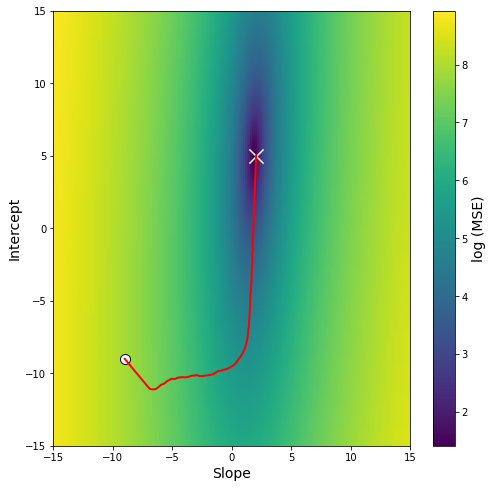

In [ ]:
pyplot.figure(figsize=(8,8))
sc=pyplot.scatter(X,Y, c=numpy.log(Z), zorder=-1)
pyplot.scatter(starts[0], starts[1], c='white', edgecolor='black', s=100)
pyplot.plot(theta_hist[:,0],theta_hist[:,1], c='red', lw=2)
pyplot.scatter(2, 5, marker='x', c='white', s=200)

cbar=pyplot.colorbar(sc)
cbar.set_label('log (MSE)', size=14)
pyplot.ylabel('Intercept', size=14)
pyplot.xlabel('Slope', size=14)
pyplot.xlim(-15,15)
pyplot.ylim(-15,15)

## 

Let's say instead that we decided to optimize this is in a pretty nonsensical fashion

In [ ]:
def MSE_simulated_data(theta, data):
    x,y=data['x'], data['y']
    y_pred=scipy.stats.norm.rvs( theta[0]*x+theta[1], 20.)
    
    return numpy.mean((y-y_pred)**2)

In [ ]:
    y_pred=scipy.stats.norm.rvs( theta[0]*x+theta[1], 20.)

In [ ]:
mse_sim_cost=costs.Model(MSE_simulated_data, data)
starts=numpy.array([-9,-9])
update_rule=updates.NADAM( beta1=.99)

In [ ]:
opt=optimizers.GradientDescent(starts,mse_sim_cost,update_rule,gradient.SPSAGradient(numpy.array([0,0])),param_stepsize=.5, param_stepdecay=0.4, param_decay_offset=0, 
                 grad_stepsize=1, grad_stepdecay=.2, )

In [ ]:
opt.update_params(gradient_reps=100, max_step=1)
for i in tqdm(range(10000)):
    opt.update_params(gradient_reps=3, max_step=1)
#     elbo.sample_rvs()

100%|██████████| 10000/10000 [00:06<00:00, 1479.64it/s]


In [ ]:
X,Y,Z=[],[],[]
for slope in numpy.arange(-15, 15,.2):

    for intercept in numpy.arange(-15, 15,.2):
        Y.append(intercept)
        X.append(slope)
        Z.append(mse_sim_cost.evaluate([slope,intercept]))


In [ ]:
theta_hist=numpy.array(opt.theta_hist)

(-15.0, 15.0)

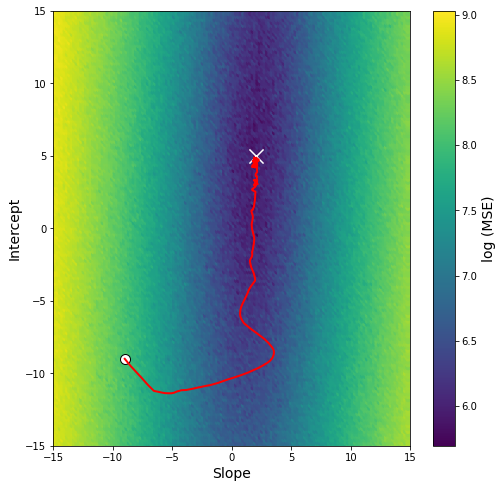

In [ ]:
pyplot.figure(figsize=(8,8))
sc=pyplot.scatter(X,Y, c=numpy.log(Z), zorder=-1, s=20)
pyplot.scatter(starts[0], starts[1], c='white', edgecolor='black', s=100)
pyplot.plot(theta_hist[:,0],theta_hist[:,1], c='red', lw=2)
pyplot.scatter(2, 5, marker='x', c='white', s=200)

cbar=pyplot.colorbar(sc)
cbar.set_label('log (MSE)', size=14)
pyplot.ylabel('Intercept', size=14)
pyplot.xlabel('Slope', size=14)
pyplot.xlim(-15,15)
pyplot.ylim(-15,15)

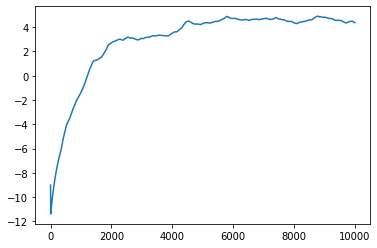

In [ ]:
pyplot.plot(theta_hist[:,1])

In [ ]:
update_rule=updates.NADAM( beta1=.9)